# MonkeyFixationDataset - CenterCrop, binned spike values, no eye data

In [1]:
import numpy as np
import matplotlib.pyplot as plt
from os import path
import datajoint as dj

import torch
from torch.utils.data import DataLoader
from tqdm import tqdm
from omegaconf import OmegaConf, open_dict

from experanto.datasets import ChunkDataset, MonkeyFixation
from experanto.utils import LongCycler, MultiEpochsDataLoader
from experanto.dataloaders import get_multisession_dataloader

In [2]:

dj.config['database.host'] = 'at-database3.stanford.edu'
dj.config['database.user'] = ''
dj.config['database.password'] = ''
ephys = dj.create_virtual_module("ephys","ephys")
session_dict = {"session_start_time" :3653578665399, 
                    "paradigm" : "fixation", 
                    "experiment": "CenterSurroundExperiment",
                    #"trial_num": 1, 
                    "files_location":"local",
                    "entire_session" : True,
                    "algorithm" : 'remodnav',
                    "parameter_setting": 'default',
                    'spike_filt_size':101,
                    'spike_filt_sigma':10,
                    'sort_method_num':5,
                    'detect_method_num':6,
                    'spikes_downsample_fs': 100}

[2025-01-12 16:19:33,041][INFO]: Connecting pavi@at-database3.stanford.edu:3306
[2025-01-12 16:19:38,008][INFO]: Connected pavi@at-database3.stanford.edu:3306


In [2]:
from experanto.configs import MONKEY_FIX_OLD as cfg
print(OmegaConf.to_yaml(cfg))

dataset:
  global_sampling_rate: null
  global_chunk_size: null
  modality_config:
    screen:
      keep_nans: false
      sampling_rate: 8.33
      chunk_size: 1
      valid_condition:
        tier: train
        valid_trial: 1
      offset: 0
      sample_stride: 1
      include_blanks: true
      transforms:
        CenterCrop:
          _target_: torchvision.transforms.v2.CenterCrop
          size: 100
        normalization: normalize
      interpolation:
        rescale: true
        rescale_size:
        - 118
        - 210
    responses:
      keep_nans: false
      sampling_rate: 100
      chunk_size: 13
      offset: 0.04
      transforms:
        normalization: null
      interpolation:
        interpolation_mode: nearest_neighbor
    eye_tracker:
      keep_nans: false
      sampling_rate: 8.33
      chunk_size: 1
      offset: 0
      transforms:
        normalization: null
      interpolation:
        interpolation_mode: nearest_neighbor
dataloader:
  batch_size: 32
  shu

In [3]:
paths = ['dynamic-monkeyDataset3744900291863-Video-7','dynamic-monkeyDataset3744900291863-Video-6','dynamic_monkeyDataset3653578665399-Video-3','dynamic-monkeyDataset3638885582960-Video-3'
        ]
full_paths = [path.join("../", f) for f in paths]

In [11]:
new_dataset = MonkeyFixation(full_paths[0], **cfg.dataset)

../dynamic-monkeyDataset3744900291863-Video-7/responses
../dynamic-monkeyDataset3744900291863-Video-7/screen


In [10]:
dataset[6]

{'responses': tensor([ 3.5423,  2.3821, 11.3147,  8.0627, 11.3046, 13.3522, 14.3898,  8.6001,
         14.7726,  8.7461, 13.0238,  4.3226,  1.8623,  2.3471,  0.0000,  1.0001,
         21.6936,  8.9527,  1.1933,  5.2353, 15.4714,  9.4572,  4.5285, 10.5744,
         16.8927, 22.7133,  8.7455,  4.8914,  4.8029,  6.2592,  3.6320,  5.6563],
        dtype=torch.float64),
 'screen': tensor([[[ 0.3700,  0.1268, -0.1669,  ..., -1.5369, -1.5315, -1.4080],
          [-0.1795,  0.0402,  0.3808,  ..., -1.6683, -1.5985, -1.4841],
          [ 0.0455,  0.3513,  0.5136,  ..., -1.6730, -1.6526, -1.4542],
          ...,
          [ 0.2504, -0.0362, -0.4279,  ..., -0.1910, -0.1510, -0.1420],
          [ 0.1294, -0.2594, -0.4826,  ..., -0.1413, -0.1126, -0.1410],
          [-0.2102, -0.1954, -0.2292,  ..., -0.1477, -0.1401, -0.1474]]],
        dtype=torch.float64),
 'timestamps': tensor([106.3598], dtype=torch.float64)}

In [11]:
len(dataset)

7500

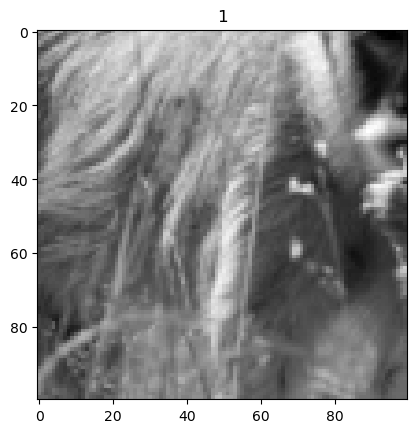

In [12]:
datapoint = dataset[6]
for i in range(len(datapoint["screen"])):
    plt.figure()
    plt.imshow(datapoint["screen"][i], cmap="gray")
    plt.title(f"{i+1}")
    plt.show()

### comparing responses - smoothed spike values in dataset and spike counts in the time window

In [27]:
all_res = []
for i in range(len(dataset)):
    all_res.append(dataset[i]['responses'])
all_res_np = np.stack([t.numpy() for t in all_res])


In [20]:

dj.config['database.host'] = 'at-database3.stanford.edu'
dj.config['database.user'] = 'pavi'
dj.config['database.password'] = 'pavi#1'
ephys = dj.create_virtual_module("ephys","ephys")
csrf = dj.create_virtual_module("george_csrf","george_csrf")


In [60]:
session_dict = {"session_start_time" :3744900291863, 
                    "paradigm" : "fixation", 
                    "experiment": "CenterSurroundExperiment",
                    #"trial_num": 1, 
                    "files_location":"local",
                    "entire_session" : True,
                    "algorithm" : 'remodnav',
                    "parameter_setting": 'default',
                    'spike_filt_size':101,
                    'spike_filt_sigma':10,
                    'sort_method_num':5,
                    'detect_method_num':6,
                    'spikes_downsample_fs': 100}

In [21]:
session_dict['sort_method_num'] = 4
session_dict['detect_method_num'] = 5

In [22]:
binned_counts = (csrf.BinnedSpikes() * csrf.StimulusTrials() & session_dict & {'latency':40,'win_size':120,'trial_type':'Train'}).fetch('binned_counts',order_by='trial_num')
binned_counts_np = np.array([each.sum(axis=1) for each in binned_counts])
binned_counts_np.shape

(7500, 32)

In [23]:
def count_spikes_in_interval(spike_times, start_time, end_time):
    """
    Count the number of spikes for each unit within a given interval.

    Args:
        spike_times: A structured array or list of arrays where each element contains spike times for a unit.
        start_time (float): The start of the interval.
        end_time (float): The end of the interval.

    Returns:
        list: A list of spike counts for each unit.
    """
    spike_counts = []
    
    for unit_spikes in spike_times:
        # Flatten the array for the current unit (in case it's nested)
        unit_spikes = unit_spikes.flatten()
        
        # Count spikes within the interval for the current unit
        count = np.sum((unit_spikes >= start_time*1000) & (unit_spikes < end_time*1000))
        spike_counts.append(count)
    
    return spike_counts

In [24]:
all_counts = []
spike_times = (ephys.Spikes() & session_dict).fetch('spike_times', order_by="unit_id")
for i in range(len(dataset)):
    datapoint = dataset[i]
    all_counts.append(count_spikes_in_interval(spike_times, datapoint['timestamps'].item()+0.04, datapoint['timestamps'].item()+0.04+0.120))
all_counts_np = np.array(all_counts)                                               

### Verifying the binnedspikes in the tables match with the number of spikes we counted manually

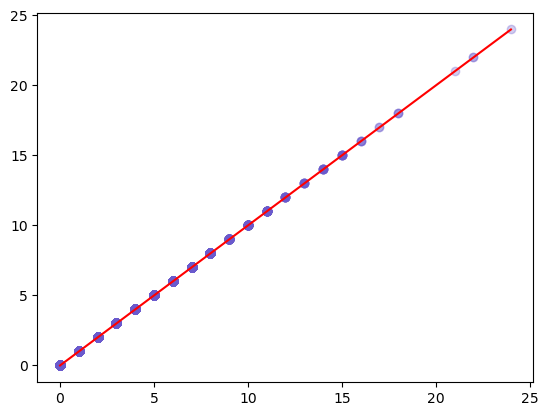

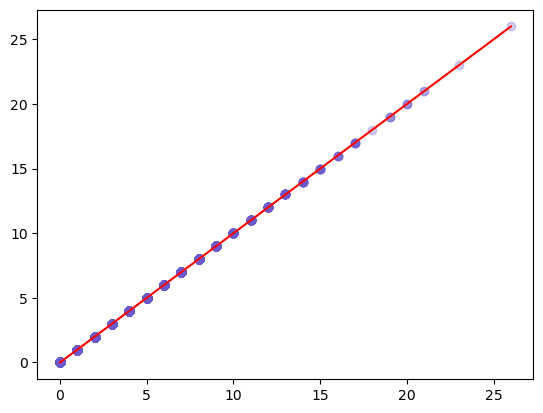

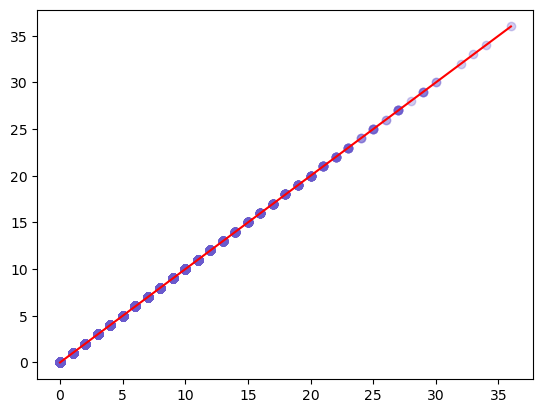

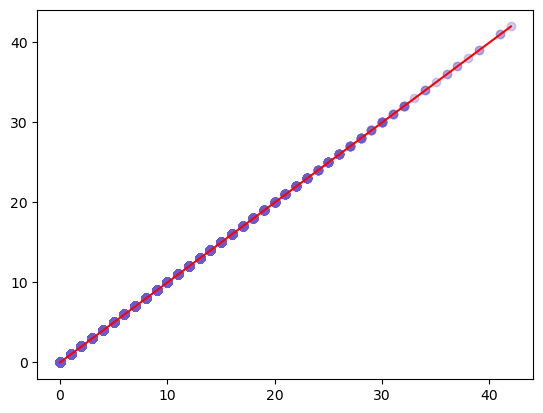

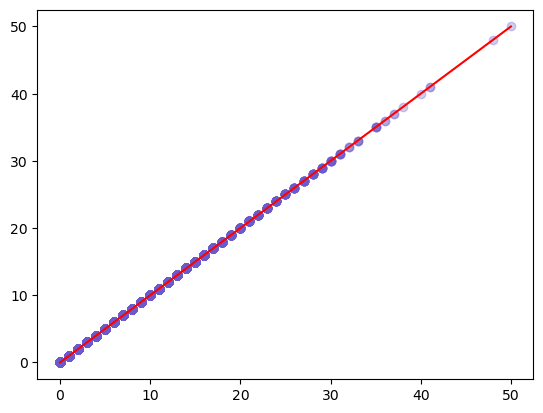

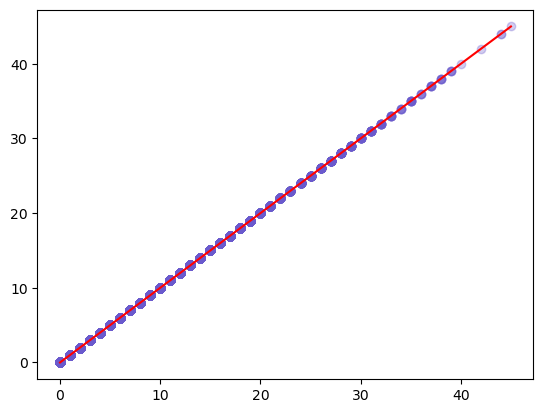

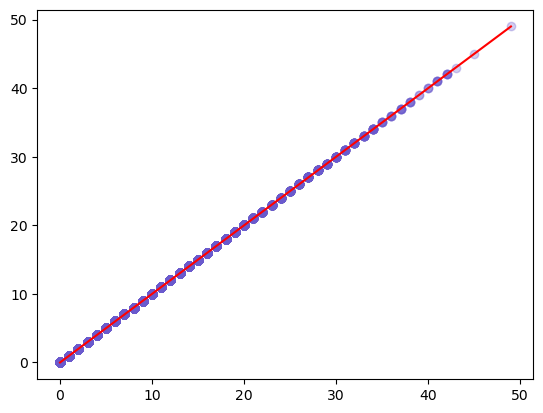

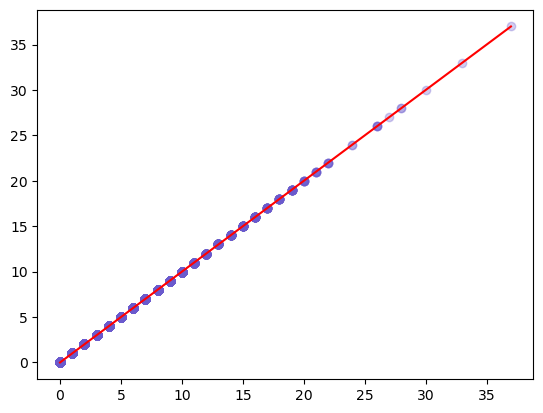

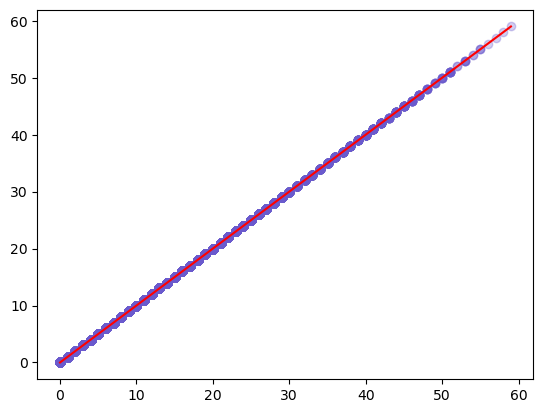

In [25]:
for i in range(9):
    x = np.linspace(0, np.max(all_counts_np.T[i]), 100)
    plt.plot(all_counts_np.T[i], binned_counts_np.T[i],'o',color='slateblue', alpha = 0.3)
    plt.plot(x,x,'r-')
    plt.show()

### Comparing the integrated smoothed spike counts in window with sum of binnedspikes in window

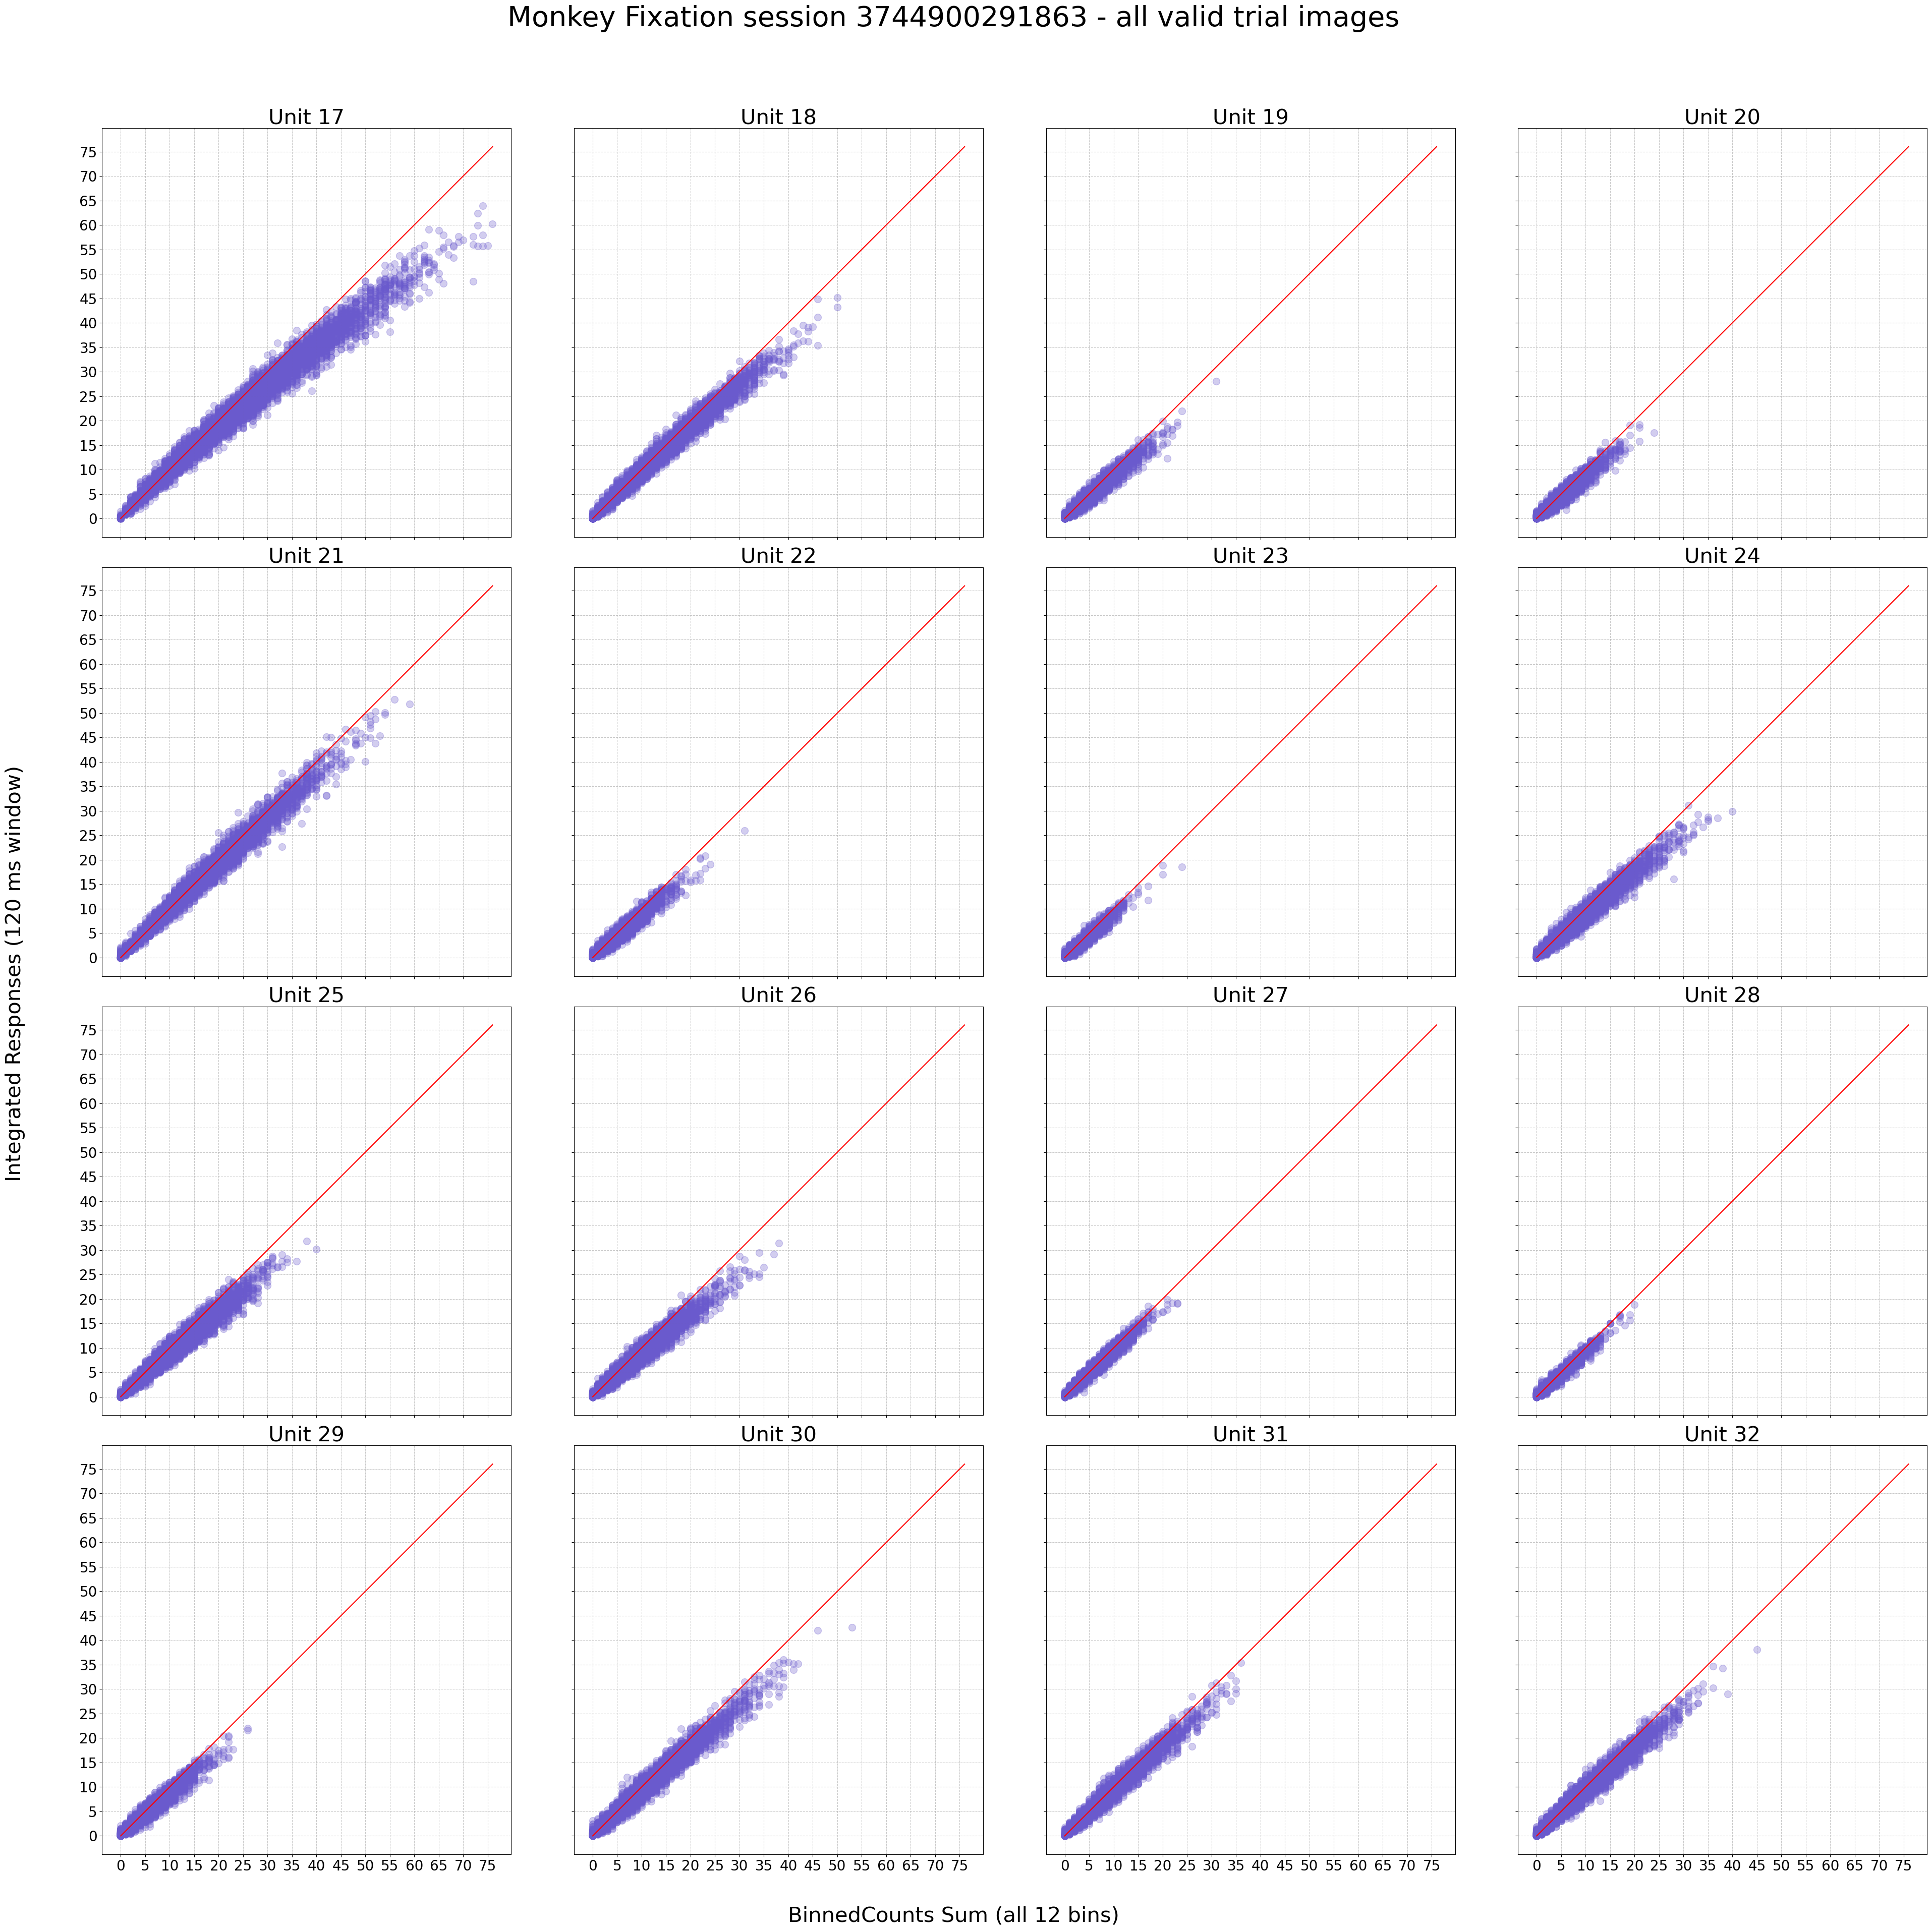

In [28]:
fig, axes = plt.subplots(4, 4, figsize=(40, 40), sharex=True, sharey=True)
x = np.linspace(0, np.max(binned_counts_np.T), int(np.max(binned_counts_np.T)))
tick_range = np.arange(0, np.ceil(np.max(binned_counts_np.T)),step=5)
fig.suptitle("Monkey Fixation session {} - all valid trial images".format(session_dict['session_start_time']), fontsize=40)
# Iterate over each subplot
for i, ax in enumerate(axes.flat):
    #ax.plot(x, y_data[i])  # Plot data in each subplot
    ax.set_title(f"Unit {i+17}",fontsize=30)
    ax.plot(binned_counts_np.T[i+16], all_res_np.T[i+16],'o', color="slateblue",alpha = 0.3, markersize=10)
    ax.plot(x,x,'r-')
    ax.set_aspect('equal')
    ax.set_xticks(tick_range)
    ax.set_yticks(tick_range)
    ax.tick_params(axis='both', labelsize=20)
    ax.grid(axis='both', linestyle='--', alpha=0.7)
fig.text(0.5, 0.03, 'BinnedCounts Sum (all 12 bins)', ha='center', fontsize=30)  # X-axis label
fig.text(0.03, 0.5, 'Integrated Responses (120 ms window)', va='center', rotation='vertical', fontsize=30)  # Y-axis label


# Reduce the space between plots and shared labels
plt.tight_layout(rect=[0.05, 0.05, 1, 0.95])
#fig.subplots_adjust(left=0.1, right=0.9, top=0.9, bottom=0.1, hspace=0.5, wspace=0.5)

plt.show()
output_file = "Monkey Fixation session {} - all valid trial images-2.png".format(session_dict['session_start_time'])
dpi_value = 300  # High resolution (300 DPI)

# Save the plot
fig.savefig(output_file, dpi=dpi_value, bbox_inches='tight')

### Checking Responses against nnvision.datasets.monkey_loaders.monkey_static_loader_combined

In [7]:
#loading nnvisiondataset - old format
#refer oldDatasetGen.ipynb


oldRes = torch.load("../DatasetResponses_3744900291863.pt")
oldRes

/tmp/ipykernel_10239/1940121660.py:5: FutureWarning: You are using `torch.load` with `weights_only=False` (the current default value), which uses the default pickle module implicitly. It is possible to construct malicious pickle data which will execute arbitrary code during unpickling (See https://github.com/pytorch/pytorch/blob/main/SECURITY.md#untrusted-models for more details). In a future release, the default value for `weights_only` will be flipped to `True`. This limits the functions that could be executed during unpickling. Arbitrary objects will no longer be allowed to be loaded via this mode unless they are explicitly allowlisted by the user via `torch.serialization.add_safe_globals`. We recommend you start setting `weights_only=True` for any use case where you don't have full control of the loaded file. Please open an issue on GitHub for any issues related to this experimental feature.
  oldRes = torch.load("../DatasetResponses_3744900291863.pt")


(tensor([14974, 19731,  7010,  ..., 14261, 10126,   127]),
 tensor([[True, True, True,  ..., True, True, True],
         [True, True, True,  ..., True, True, True],
         [True, True, True,  ..., True, True, True],
         ...,
         [True, True, True,  ..., True, True, True],
         [True, True, True,  ..., True, True, True],
         [True, True, True,  ..., True, True, True]]),
 tensor([[ 0.,  5.,  7.,  ...,  4.,  9., 10.],
         [ 0.,  0.,  9.,  ...,  4.,  2.,  6.],
         [ 0.,  0.,  1.,  ...,  2.,  3.,  3.],
         ...,
         [ 0.,  5., 14.,  ...,  1.,  1.,  2.],
         [ 1., 12.,  9.,  ...,  8.,  5.,  5.],
         [ 0.,  1., 10.,  ...,  5.,  5.,  3.]]))

In [29]:
match_order_idx = []
old_imageOrder = oldRes[0]
new_imageOrder = []
for i in range(len(new_dataset)):
    new_imageOrder.append(new_dataset[i]['screen_meta'])

In [33]:
new_imageOrder = np.array([int(each) if type(each) == str else each for each in new_imageOrder])


In [48]:
reordered_new = []
old = []
for i, id in enumerate(old_imageOrder):
    idx_in_new = np.where(new_imageOrder == id.item())
    if(len(idx_in_new[0])):
        reordered_new.append(new_dataset[idx_in_new]['responses'])
        old.append(oldRes[2][i])
reordered_new = np.array(reordered_new)
old = np.array(old)
reordered_new

array([[0.00000000e+00, 5.64326916e+00, 8.96729621e+00, ...,
        3.99227947e+00, 1.00705921e+01, 1.13825838e+01],
       [0.00000000e+00, 8.85257905e-01, 1.07238879e+01, ...,
        4.61896287e+00, 3.28167513e+00, 8.80227022e+00],
       [0.00000000e+00, 4.40293853e-01, 9.15761547e-01, ...,
        2.01036520e+00, 2.75260486e+00, 2.88482786e+00],
       ...,
       [6.93582737e-01, 5.30833919e+00, 1.37751024e+01, ...,
        9.99999443e-01, 4.51089752e-01, 1.45741042e+00],
       [1.00000001e+00, 1.38485334e+01, 1.02485189e+01, ...,
        8.71771223e+00, 4.89711113e+00, 5.74220712e+00],
       [6.82841384e-04, 1.47033380e+00, 1.06607706e+01, ...,
        4.97502160e+00, 6.29818994e+00, 3.05743633e+00]])

In [55]:
len(old) == len(reordered_new)

True

In [56]:
n_units = old.shape[1]
n_units

15

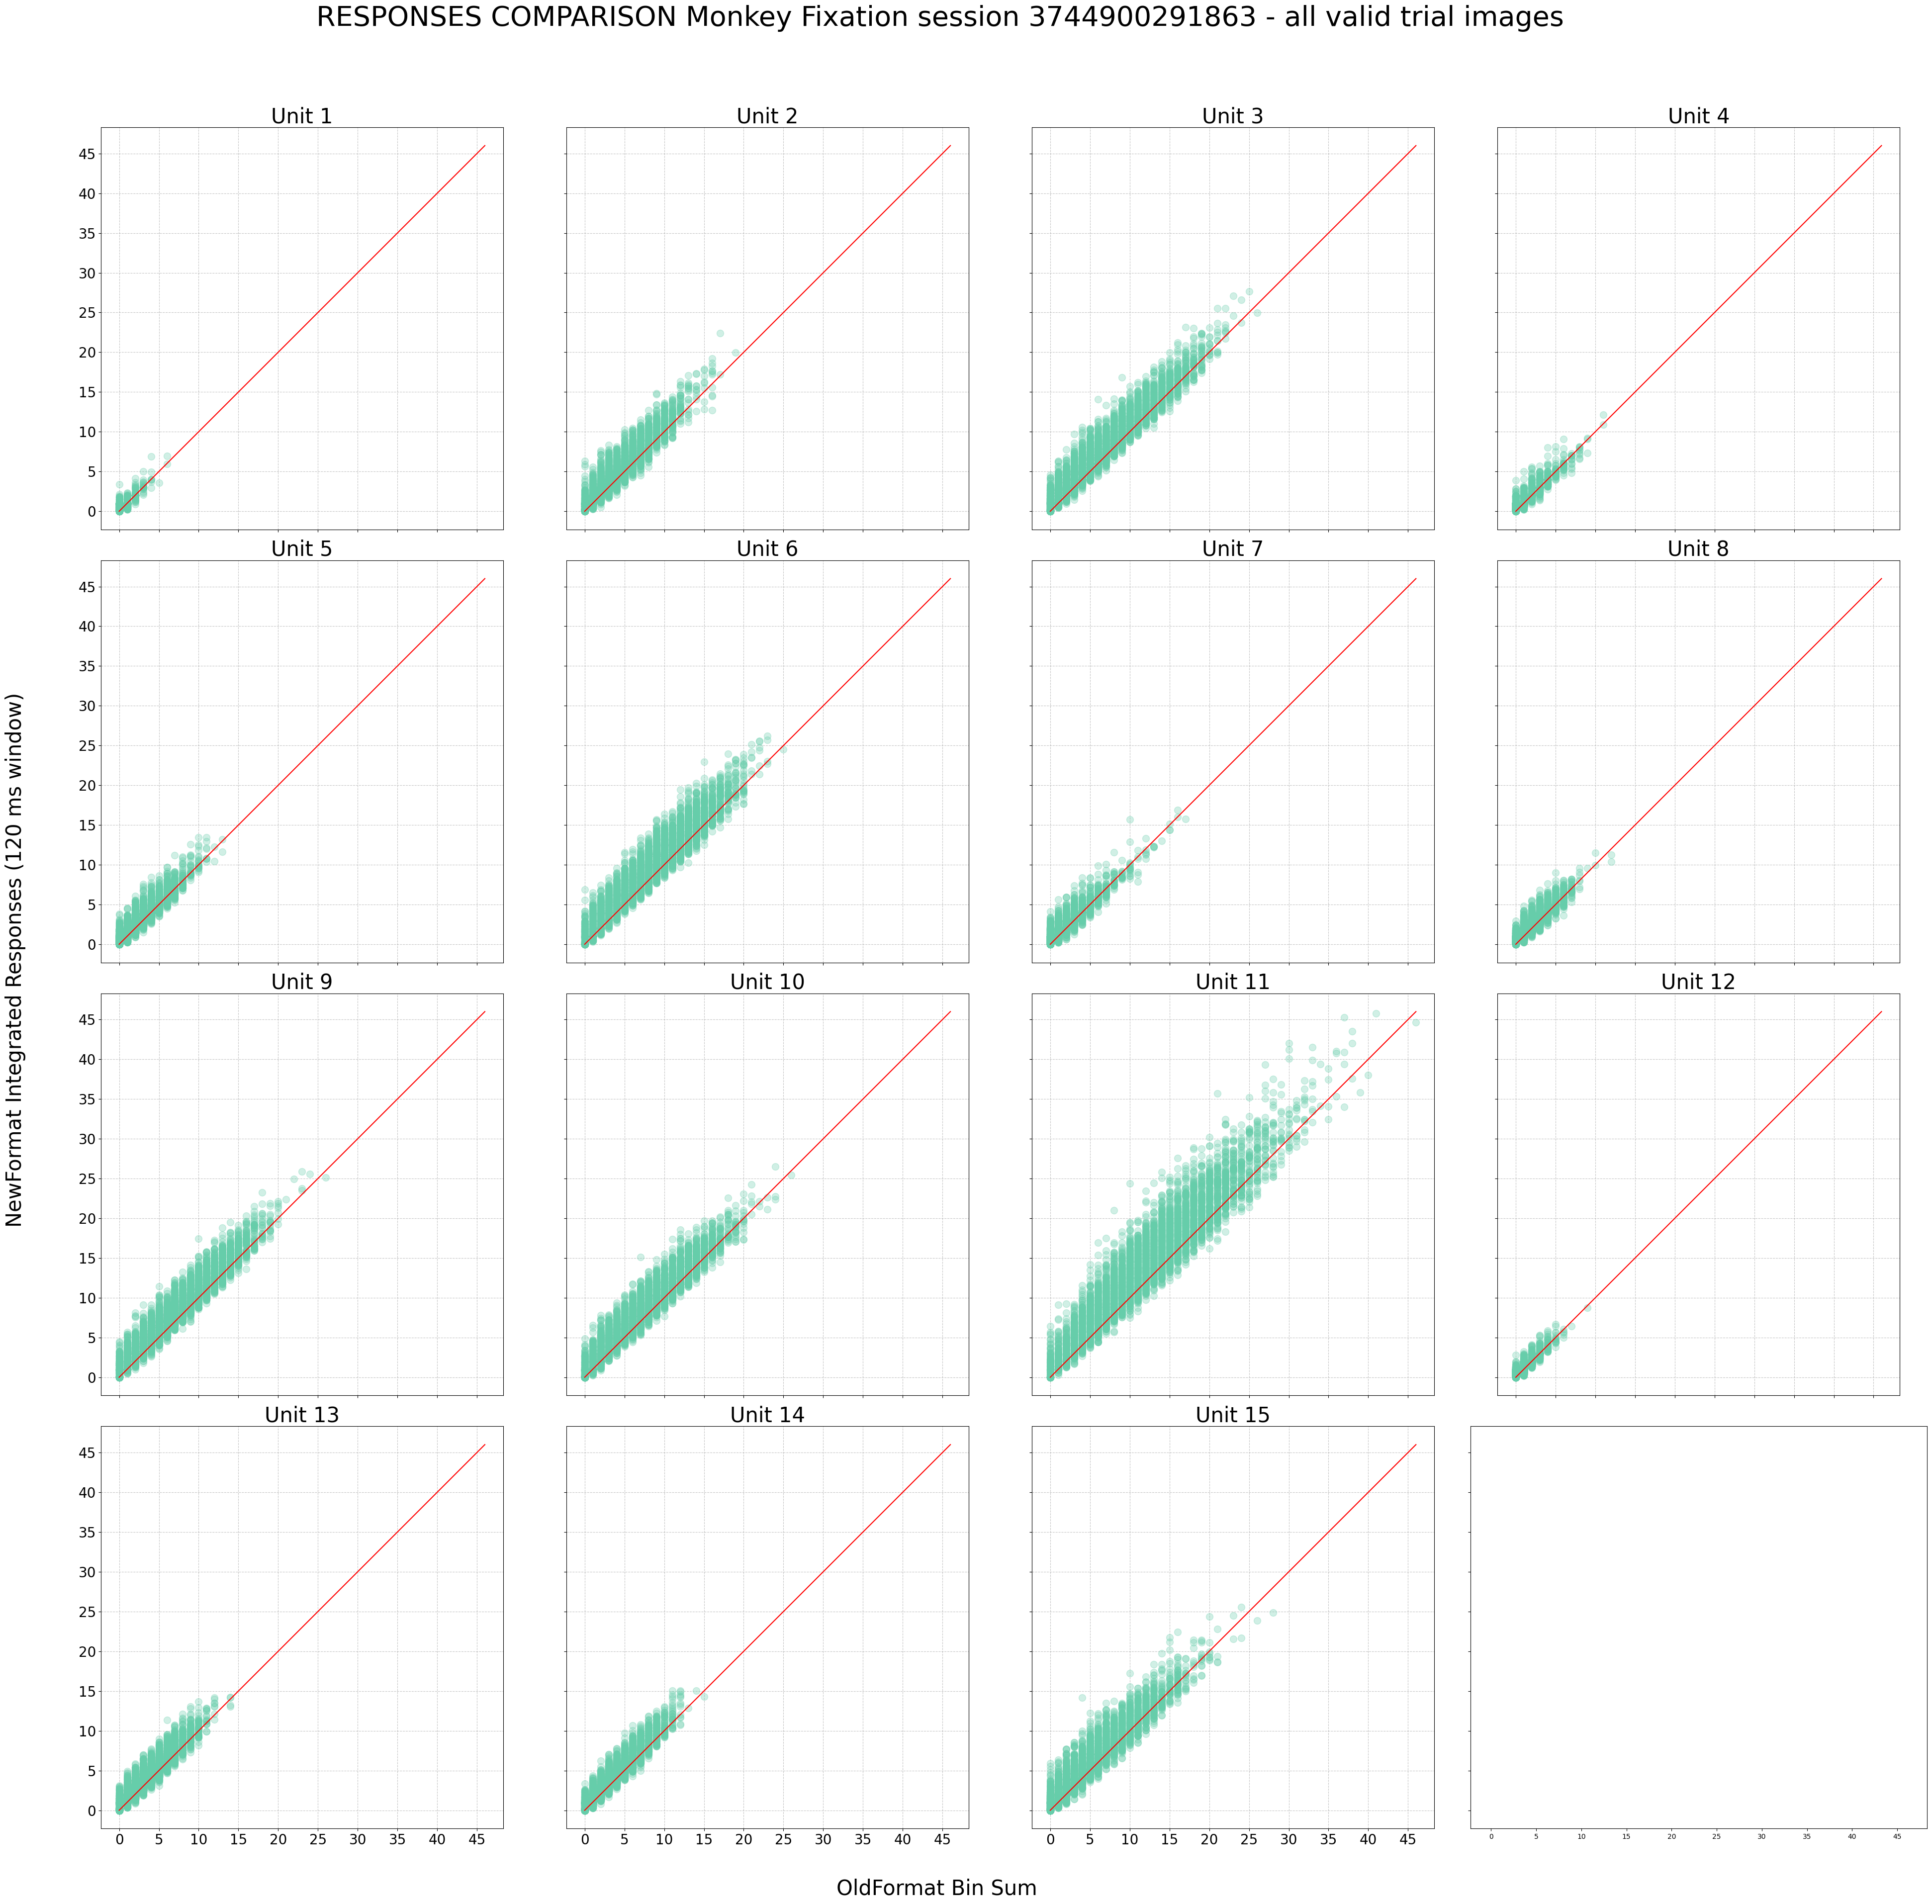

In [69]:
fig, axes = plt.subplots(4, 4, figsize=(40, 40), sharex=True, sharey=True)
x = np.linspace(0, np.max(old.T), int(np.max(old.T)))
tick_range = np.arange(0, np.ceil(np.max(old.T)),step=5)
fig.suptitle("RESPONSES COMPARISON Monkey Fixation session {} - all valid trial images".format(session_dict['session_start_time']), fontsize=40)
# Iterate over each subplot
for i, ax in enumerate(axes.flat):
    if(i <= n_units-1):
    #ax.plot(x, y_data[i])  # Plot data in each subplot
        ax.set_title(f"Unit {i+1}",fontsize=30)
        ax.plot(old.T[i], reordered_new.T[i],'o', color="mediumaquamarine",alpha = 0.3, markersize=10)
        ax.plot(x,x,'r-')
        ax.set_aspect('equal')
        ax.set_xticks(tick_range)
        ax.set_yticks(tick_range)
        ax.tick_params(axis='both', labelsize=20)
        ax.grid(axis='both', linestyle='--', alpha=0.7)
fig.text(0.5, 0.03, 'OldFormat Bin Sum ', ha='center', fontsize=30)  # X-axis label
fig.text(0.03, 0.5, 'NewFormat Integrated Responses (120 ms window)', va='center', rotation='vertical', fontsize=30)  # Y-axis label


# Reduce the space between plots and shared labels
plt.tight_layout(rect=[0.05, 0.05, 1, 0.95])
#fig.subplots_adjust(left=0.1, right=0.9, top=0.9, bottom=0.1, hspace=0.5, wspace=0.5)

plt.show()
output_file = "Monkey Fixation session {} - NewVsOldDatset_Responses.png".format(session_dict['session_start_time'])
dpi_value = 300  # High resolution (300 DPI)

# Save the plot
fig.savefig(output_file, dpi=dpi_value, bbox_inches='tight')

### Comparing Images

In [83]:
oldStim = torch.load('../DatasetImages_3744900291863.pt')
oldStim

/tmp/ipykernel_10239/1991698687.py:1: FutureWarning: You are using `torch.load` with `weights_only=False` (the current default value), which uses the default pickle module implicitly. It is possible to construct malicious pickle data which will execute arbitrary code during unpickling (See https://github.com/pytorch/pytorch/blob/main/SECURITY.md#untrusted-models for more details). In a future release, the default value for `weights_only` will be flipped to `True`. This limits the functions that could be executed during unpickling. Arbitrary objects will no longer be allowed to be loaded via this mode unless they are explicitly allowlisted by the user via `torch.serialization.add_safe_globals`. We recommend you start setting `weights_only=True` for any use case where you don't have full control of the loaded file. Please open an issue on GitHub for any issues related to this experimental feature.
  oldStim = torch.load('../DatasetImages_3744900291863.pt')


{7010: tensor([[[ 0.3082,  0.2797,  0.3224,  ...,  0.6924,  0.5359,  0.4647],
          [ 0.1801,  0.1517,  0.2228,  ...,  0.6924,  0.6355,  0.6639],
          [ 0.2940,  0.3082,  0.3224,  ...,  0.7208,  0.7208,  0.6924],
          ...,
          [ 0.5359, -0.6309, -1.0720,  ..., -0.1187,  0.8489,  0.9343],
          [ 0.7208,  0.7208,  0.4932,  ...,  1.1192,  1.1477,  1.2046],
          [ 0.9769,  0.8204,  0.7493,  ...,  1.2046,  0.8916,  0.6497]],
 
         [[ 0.3082,  0.2797,  0.3224,  ...,  0.6924,  0.5359,  0.4647],
          [ 0.1801,  0.1517,  0.2228,  ...,  0.6924,  0.6355,  0.6639],
          [ 0.2940,  0.3082,  0.3224,  ...,  0.7208,  0.7208,  0.6924],
          ...,
          [ 0.5359, -0.6309, -1.0720,  ..., -0.1187,  0.8489,  0.9343],
          [ 0.7208,  0.7208,  0.4932,  ...,  1.1192,  1.1477,  1.2046],
          [ 0.9769,  0.8204,  0.7493,  ...,  1.2046,  0.8916,  0.6497]],
 
         [[ 0.3082,  0.2797,  0.3224,  ...,  0.6924,  0.5359,  0.4647],
          [ 0.1801,  0

In [85]:
correlations = []
old_image_ids = oldStim.keys()
for i, id in enumerate(old_image_ids):
    idx_in_new = np.where(new_imageOrder == id)
    if(len(idx_in_new[0])):
        print(id)
        rni = (new_dataset[idx_in_new]['screen'][0]).flatten()
        oi = oldStim[id][0].flatten()
        correlation = torch.corrcoef(torch.stack([rni, oi]))[0, 1].item()
        correlations.append(correlation)

correlations

7010
5612
21835
12903
4055
4723
10208
17452
19379
18777
17201
14749
7722
2836
16021
19507
20844
8654
20635
920
19632
12474
6017
7342
9410
10012
657
21097
3042
17890
2229
4080
3068
15149
11624
18649
17110
2934
1122
6018
4762
6383
11510
3244
6671
16014
21211
5003
530
20549
21082
5514
10835
9015
19530
9210
17194
15392
16942
16320
15028
18739
16834
1407
10585
6826
5851
16609
8928
9941
822
19077
265
14974
19731
3735
3544
14612
1493
21354
4868
12387
7586
23264
14208
7882
21805
12282
6514
7833
18140
4047
23980
6915
2315
21235
4513
746
10937
23313
14967
14148
11795
10759
5496
8254
11072
5127
18951


/tmp/ipykernel_10239/1593013380.py:4: DeprecationWarning: Calling nonzero on 0d arrays is deprecated, as it behaves surprisingly. Use `atleast_1d(cond).nonzero()` if the old behavior was intended. If the context of this warning is of the form `arr[nonzero(cond)]`, just use `arr[cond]`.
  idx_in_new = np.where(new_imageOrder == id)


11916
2482
14141
22262
3301
13842
23979
5817
10889
11450
18829
13729
22949
20220
18038
16868
22565
1985
81
15991
17646
20185
2187
3750
17796
17771
3129
22317
18935
14840
5921
10684
20249
23809
9983
21224
5681
9186
17207
20535
14003
1051
8029
4145
18622
19265
4598
22775
11903
5005
406
16707
11032
23139
14791
22483
4111
15434
15152
15815
5918
4000
12252
8524
19572
18034
15247
14876
15254
8814
13706
15320
4329
9768
734
15945
10439
1889
17192
8801
6863
18107
24002
5053
20751
19280
1239
19917
14080
9867
14388
19175
3115
9707
12171
16418
20682
7657
20845
13098
14802
23269
4274
3461
12627
15083
5231
2478
6415
19551
16902
15597
11953
13912
1182
23064
12030
13790
20274
3533
14268
23992
3952
8626
13693
4538
4547
23423
3608
14980
5248
3148
12891
10569
14577
11201
2841
17903
7995
11734
16842
3671
574
4454
3740
8632
7948
7640
21780
16083
21580
24013
9262
6640
9756
284
10980
23743
15245
9237
18863
13943
12508
14347
8340
3753
15725
23850
9347
10539
4559
10457
6143
2575
23499
20358
7034
23590
17409
17

[0.9999593094255909,
 0.9999811790335209,
 0.9999654945770171,
 0.9999725321712564,
 0.9999812652200095,
 0.9998713247036322,
 0.9999817554103757,
 0.9999697188428663,
 0.9999640677637058,
 0.9999800517679586,
 0.9999575334528673,
 0.9999698098482989,
 0.9999800110177721,
 0.9999719469570981,
 0.9998842083650685,
 0.9999411443436443,
 0.9998928501550938,
 0.999984973112203,
 0.9999891091621546,
 0.9999880975565949,
 0.9999580318744024,
 0.9999761861546986,
 0.9999845208805606,
 0.9999851882756786,
 0.9999677984782923,
 0.9997789820775215,
 0.9999680524848295,
 0.9999577562382798,
 0.9999754936815083,
 0.9999697049962377,
 0.9999762428636169,
 0.9998556014332135,
 0.999932659366211,
 0.9999757891551911,
 0.9999652568506932,
 0.9999854592311824,
 0.9999590363424349,
 0.9999285040868051,
 0.9999753952891672,
 0.9999851072159144,
 0.9999123684874188,
 0.9999481020879442,
 0.999980371799171,
 0.9999903388803626,
 0.9999780985736827,
 0.9998441703482859,
 0.9999334015625115,
 0.9999242606319

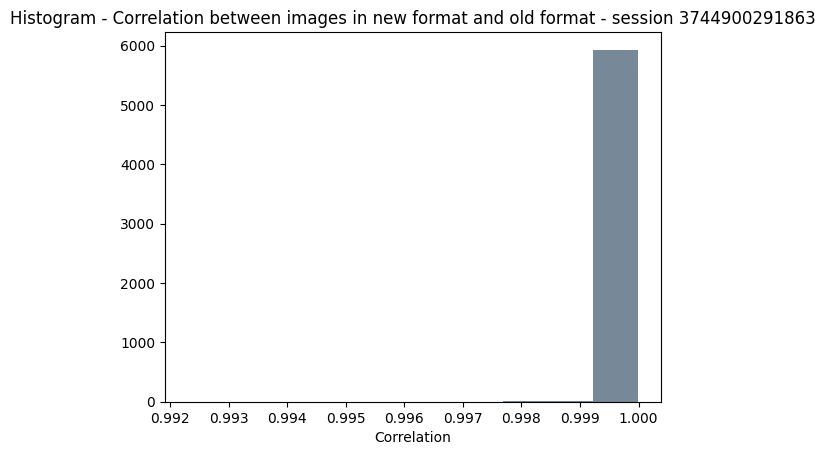

In [97]:
plt.hist(correlations, color='lightslategrey')
plt.xlabel("Correlation")
plt.title("Histogram - Correlation between images in new format and old format - session {}".format(session_dict['session_start_time']))
plt.savefig("Image Correlation Histogram - session {}".format(session_dict['session_start_time']), dpi=300)
plt.show()

### Visual confirmation

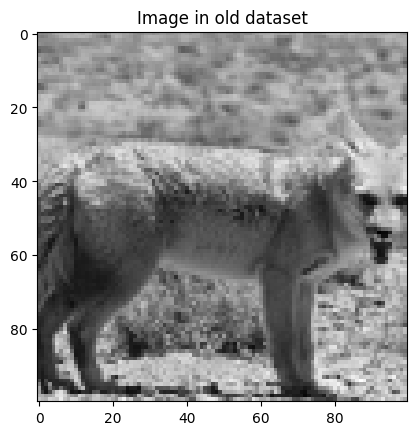

In [113]:
plt.title("Image in old dataset")
plt.imshow(oldStim[7010][0], cmap="gray")

In [110]:
idx_in_new = np.where(new_imageOrder == 7010)
idx_in_new

(array([4087]),)

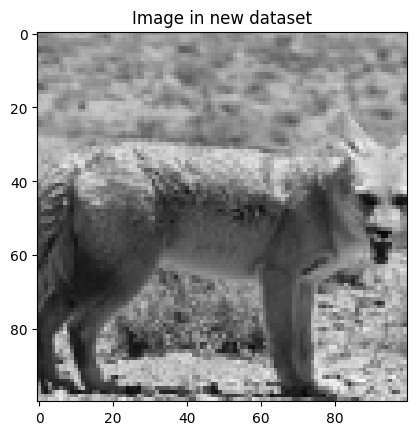

In [112]:
plt.title("Image in new dataset")
plt.imshow(new_dataset[idx_in_new]['screen'][0], cmap="gray")